In [1]:
!pip3 install torch torchvision matplotlib tqdm


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install segmentation_models_pytorch


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from losses import *

In [5]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        target_size = (256, 192)
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB").resize(target_size)
        mask = Image.open(mask_path).convert("L").resize(target_size)  # Assuming masks are in grayscale
        mask = np.array(mask)
        mmask = np.zeros((11, mask.shape[0], mask.shape[1]), dtype=np.int8)
        for i, line in enumerate(mask):
            for j, pix in enumerate(line):
                mmask[pix][i][j] = 1
        if self.transform:
            image = self.transform(image)
            # mmask = self.transform(mmask)
        return image, torch.Tensor(mmask)
        # except Exception as e: 
        #     print(e)
        #     return None, None

In [6]:

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((1024, 768)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_dataset = CustomSegmentationDataset("./res_data/train/images/001", "./res_data/train/masks/001", transform)
val_dataset = CustomSegmentationDataset("./res_data/val/images", "./res_data/val/masks", transform)
test_dataset = CustomSegmentationDataset("./res_data/test/images", "./res_data/test/masks", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

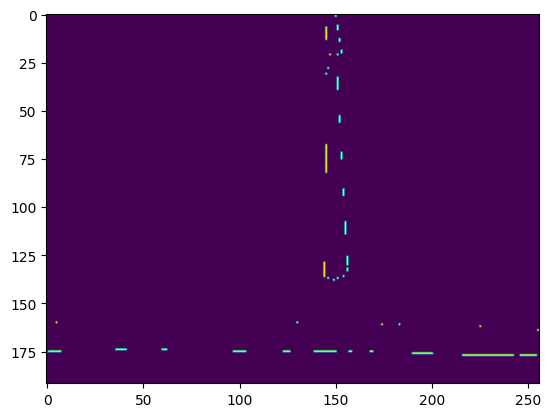

In [8]:
import matplotlib.pyplot as plt

mn_pix = 1000
mx_pix = 0
for i, (im, mask) in enumerate(train_dataset):
    plt.imshow(mask[6])
    break

In [9]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=11,                      # model output channels (number of classes in your dataset)
)

/Users/ilya/Documents/segml/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from utils.train import TrainEpoch, ValidEpoch
from utils.metrics import IoU

loss = JaccardLoss('multilabel')
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])
train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=[], 
    optimizer=optimizer,
    device='mps',
    verbose=True,
)

valid_epoch = ValidEpoch(
    model,
    device='mps',
    verbose=True,
    loss=loss, 
    metrics=[], 
)

In [ ]:
for i in range(50):
    try:
        train_epoch.run(train_loader)
    except Exception as e:
        print(e)
    try:
        valid_epoch.run(val_loader)
    except Exception as e:
        print(e)
        

train: 100%|█████████▉| 361/362 [04:45<00:00,  1.27it/s, loss - 0.4095]
Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
valid:  94%|█████████▍| 106/113 [01:10<00:04,  1.50it/s, loss - 0.4621]
[Errno 2] No such file or directory: '/Users/ilya/Documents/segml/res_data/val/masks/9313.jpg'
train: 100%|█████████▉| 361/362 [04:31<00:00,  1.33it/s, loss - 0.4074]
Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
valid:  94%|█████████▍| 106/113 [01:10<00:04,  1.50it/s, loss - 0.4582]
[Errno 2] No such file or directory: '/Users/ilya/Documents/segml/res_data/val/masks/9313.jpg'
train: 100%|█████████▉| 361/362 [04:31<00:00,  1.33it/s, loss - 0.4107]
Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
valid:  94%|█████████▍| 106/113 [01:10<00:04,  1.50it/s, loss - 0.466] 
[Errno 2] No such file or directory: '/Users/ilya/Documents/segml/res_data/val/masks/9313.

KeyboardInterrupt: 

In [ ]:
print(torch.device('cpu'))
for img, mask in val_loader:
    img = img.to('mps')
    print('fuck')
    outputs = model(img)
    print(type(outputs), outputs.shape)
    break

cpu
fuck
<class 'torch.Tensor'> torch.Size([4, 11, 192, 256])


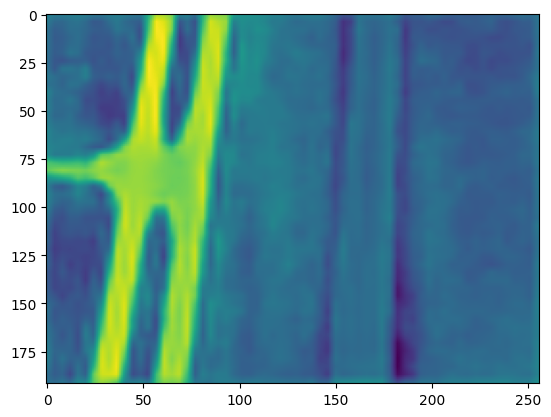

In [ ]:
plt.imshow(outputs.cpu().detach().numpy()[1][4])

In [ ]:
torch.save(model, 'model1.pth')